# Convolutional Neural Networks (CNN)


This notebook is a modified version of the [original Kaggle Tutorial](https://www.kaggle.com/kanncaa1/convolutional-neural-network-cnn-tutorial). I extended the training data using the full training data from the [MNIST Database](http://yann.lecun.com/exdb/mnist/), which consists of 60,000 training examples and labels. To get the database in a CSV format, I used [this Kaggle dataset](https://www.kaggle.com/oddrationale/mnist-in-csv?select=mnist_train.csv).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['mnistdata', 'digit-recognizer']


<a id="1"></a>
## Loading the Data Set
* In this part we load and visualize the data.

In [2]:
# read train 
# Original Notebook: train = pd.read_csv("../input/digit-recognizer/train.csv")

# UPDATED (using full training data from MNIST database):
train = pd.read_csv("../input/mnistdata/mnist_train.csv")
print(train.shape)
train.head()

(60000, 785)


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,1x10,1x11,1x12,1x13,1x14,1x15,1x16,1x17,1x18,1x19,1x20,1x21,1x22,1x23,1x24,1x25,1x26,1x27,1x28,2x1,2x2,2x3,2x4,2x5,2x6,2x7,2x8,2x9,2x10,2x11,...,27x17,27x18,27x19,27x20,27x21,27x22,27x23,27x24,27x25,27x26,27x27,27x28,28x1,28x2,28x3,28x4,28x5,28x6,28x7,28x8,28x9,28x10,28x11,28x12,28x13,28x14,28x15,28x16,28x17,28x18,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,147,252,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [3]:
# read test 
test= pd.read_csv("../input/digit-recognizer/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
# put labels into y_train variable
Y_train = train["label"]
# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

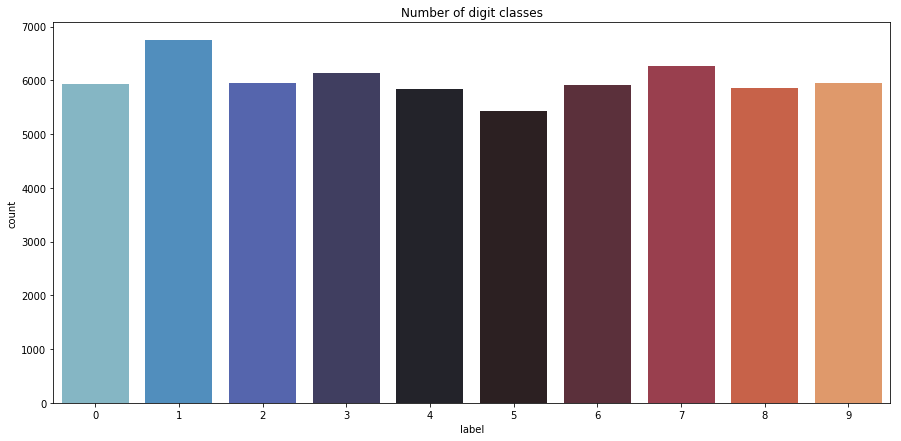

In [5]:
# visualize number of digits classes
plt.figure(figsize=(15,7))
g = sns.countplot(Y_train, palette="icefire")
plt.title("Number of digit classes")
Y_train.value_counts()

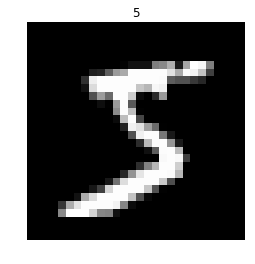

In [6]:
# plot some samples
img = X_train.iloc[0].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[0,0])
plt.axis("off")
plt.show()

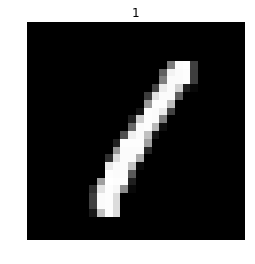

In [7]:
# plot some samples
img = X_train.iloc[3].as_matrix()
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(train.iloc[3,0])
plt.axis("off")
plt.show()

<a id="2"></a>
## Normalization, Reshape and Label Encoding 
* Normalization
    * We perform a grayscale normalization to reduce the effect of illumination's differences.
    * If we perform normalization, CNN works faster.
* Reshape
    * Train and test images (28 x 28) 
    * We reshape all data to 28x28x1 3D matrices.
    * Keras needs an extra dimension in the end which correspond to channels. Our images are gray scaled so it use only one channel. 
* Label Encoding  
    * Encode labels to one hot vectors 
        * 2 => [0,0,1,0,0,0,0,0,0,0]
        * 4 => [0,0,0,0,1,0,0,0,0,0]

In [8]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (60000, 784)
test shape:  (28000, 784)


In [9]:
# Reshape
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
print("x_train shape: ",X_train.shape)
print("test shape: ",test.shape)

x_train shape:  (60000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [10]:
# Label Encoding 
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

Using TensorFlow backend.


<a id="3"></a>
## Train Test Split
* We split the data into train and test sets.
* test size is 10%.
* train size is 90%.

In [11]:
# Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)
print("x_train shape",X_train.shape)
print("x_test shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_test shape",Y_val.shape)

x_train shape (54000, 28, 28, 1)
x_test shape (6000, 28, 28, 1)
y_train shape (54000, 10)
y_test shape (6000, 10)


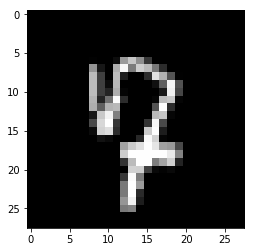

In [12]:
# Some examples
plt.imshow(X_train[2][:,:,0],cmap='gray')
plt.show()

<a id="4"></a>
## Convolutional Neural Network 
* CNN is used for image classification, object detection 
* <a href="https://ibb.co/kV1j9p"><img src="https://preview.ibb.co/nRkBpp/gec2.jpg" alt="gec2" border="0"></a>

<a id="5"></a>
### What is Convolution Operation?
* We have some image and feature detector(3*3)
* Feature detector does not need to be 3 by 3 matrix. It can be 5 by 5 or 7 by 7.
* Feature detector = kernel = filter
* Feauture detector detects features like edges or convex shapes. Example, if out input is dog, feature detector can detect features like ear or tail of the dog.
* feature map = conv(input image, feature detector). Element wise multiplication of matrices.
* feature map = convolved feature
* Stride = navigating in input image.
* We reduce the size of image. This is important bc code runs faster. However, we lost information. 
* We create multiple feature maps bc we use multiple feature detectors(filters).
* Lets look at gimp. Edge detect: [0,10,0],[10,-4,10],[0,10,0]
* <a href="https://imgbb.com/"><img src="https://image.ibb.co/m4FQC9/gec.jpg" alt="gec" border="0"></a>
* After having convolution layer we use ReLU to break up linearity. Increase nonlinearity. Because images are non linear.
* <a href="https://ibb.co/mVZih9"><img src="https://preview.ibb.co/gbcQvU/RELU.jpg" alt="RELU" border="0"></a>

<a id="6"></a>
### Same Padding
* As we keep applying conv layers, the size of the volume will decrease faster than we would like. In the early layers of our network, we want to preserve as much information about the original input volume so that we can extract those low level features.
* input size and output size are same.
* <a href="https://ibb.co/jUPkUp"><img src="https://preview.ibb.co/noH5Up/padding.jpg" alt="padding" border="0"></a>

<a id="7"></a>
### Max Pooling
* It makes down-sampling or sub-sampling (Reduces the number of parameters)
* It makes the detection of features invariant to scale or orientation changes.
* It reduce the amount of parameters and computation in the network, and hence to also control overfitting. 
* <a href="https://ibb.co/ckTjN9"><img src="https://preview.ibb.co/gsNYFU/maxpool.jpg" alt="maxpool" border="0"></a>

<a id="8"></a>
### Flattening
* <a href="https://imgbb.com/"><img src="https://image.ibb.co/c7eVvU/flattenigng.jpg" alt="flattenigng" border="0"></a>

<a id="9"></a>
### Full Connection
* Neurons in a fully connected layer have connections to all activations in the previous layer
* Artificial Neural Network
* <a href="https://ibb.co/hsS14p"><img src="https://preview.ibb.co/evzsAU/fullyc.jpg" alt="fullyc" border="0"></a>

<a id="10"></a>
## Implementing with Keras

<a id="11"></a>
### Create Model
* conv => max pool => dropout => conv => max pool => dropout => fully connected (2 layer)
* Dropout: Dropout is a technique where randomly selected neurons are ignored during training
* <a href="https://ibb.co/jGcvVU"><img src="https://preview.ibb.co/e7yPPp/dropout.jpg" alt="dropout" border="0"></a>

In [13]:
# 
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

<a id="12"></a>
### Define Optimizer   
* Adam optimizer: Change the learning rate


In [14]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

<a id="13"></a>
### Compile Model
* categorical crossentropy
* We make binary cross entropy at previous parts and in machine learning tutorial
* At this time we use categorical crossentropy. That means that we have multi class.
* <a href="https://ibb.co/jm1bpp"><img src="https://preview.ibb.co/nN3ZaU/cce.jpg" alt="cce" border="0"></a>


In [15]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

<a id="14"></a>
### Epochs and Batch Size
* Say you have a dataset of 10 examples (or samples). You have a **batch size** of 2, and you've specified you want the algorithm to run for 3 **epochs**. Therefore, in each epoch, you have 5 **batches** (10/2 = 5). Each batch gets passed through the algorithm, therefore you have 5 iterations **per epoch**.
* reference: https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks

In [16]:
epochs = 10  # for better result increase the epochs
batch_size = 250

<a id="15"></a>
### Data Augmentation
* To avoid overfitting problem, we need to expand artificially our handwritten digit dataset
* Alter the training data with small transformations to reproduce the variations of digit.
* For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated.
* <a href="https://ibb.co/k24CUp"><img src="https://preview.ibb.co/nMxXUp/augment.jpg" alt="augment" border="0"></a>
    


In [17]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

<a id="16"></a>
### Fit the model

In [18]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/10
216/216 [==============================] - 38s 175ms/step - loss: 0.9827 - acc: 0.6728 - val_loss: 0.1812 - val_acc: 0.9528
Epoch 2/10
216/216 [==============================] - 37s 172ms/step - loss: 0.3875 - acc: 0.8781 - val_loss: 0.1161 - val_acc: 0.9663
Epoch 3/10
216/216 [==============================] - 37s 172ms/step - loss: 0.2910 - acc: 0.9097 - val_loss: 0.0911 - val_acc: 0.9722
Epoch 4/10
216/216 [==============================] - 37s 172ms/step - loss: 0.2409 - acc: 0.9245 - val_loss: 0.0767 - val_acc: 0.9773
Epoch 5/10
216/216 [==============================] - 37s 173ms/step - loss: 0.2127 - acc: 0.9349 - val_loss: 0.0699 - val_acc: 0.9787
Epoch 6/10
216/216 [==============================] - 37s 172ms/step - loss: 0.1918 - acc: 0.9410 - val_loss: 0.0600 - val_acc: 0.9815
Epoch 7/10
216/216 [==============================] - 37s 171ms/step - loss: 0.1774 - acc: 0.9451 - val_loss: 0.0554 - val_acc: 0.9827
Epoch 8/10
216/216 [==============================] - 3

<a id="17"></a>
### Evaluate the model
* Test Loss visualization
* Confusion matrix


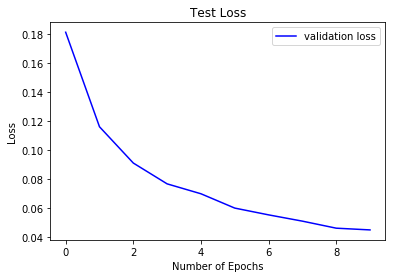

In [19]:
# Plot the loss and accuracy curves for training and validation 
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

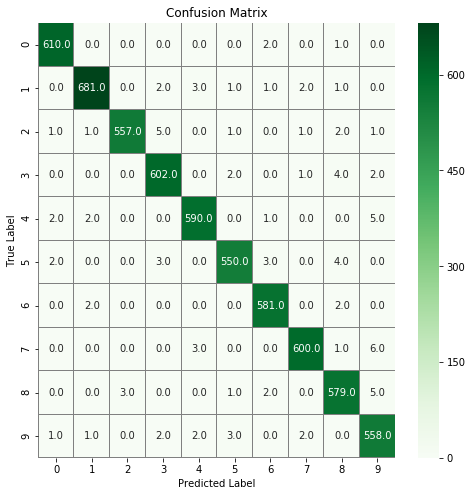

In [20]:
# confusion matrix
import seaborn as sns
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<a id="18"></a>
## Conclusion
* http://scs.ryerson.ca/~aharley/vis/conv/flat.html